In [1]:
# download seaborn
#!pip install seaborn

In [2]:
# Import Statements
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets

medicare_tele_trends = pd.read_csv('data/raw/Medicare Telehealth Trends.csv')
telemedicine_use = pd.read_csv('data/raw/Telemedicine Use in the Last 4 Weeks.csv')
telemedicine_services = pd.read_csv('data/raw/Telehealth Services Provided to the MedicaidCHIP Population.csv')

print(medicare_tele_trends.shape)
print(telemedicine_use.shape)
print(telemedicine_services.shape)

(26488, 13)
(3344, 15)
(12720, 8)


In [4]:
# Data Cleaning for Medicare Telehealth Trends

# Drop irrelevant columns
medicare_tele_trends_clean = medicare_tele_trends.drop(columns= ['Bene_Mdcd_Mdcr_Enrl_Stus',
                                                                'Bene_Race_Desc',
                                                                'Bene_Mdcr_Entlmt_Stus',
                                                                'Bene_RUCA_Desc',
                                                                'Total_PartB_Enrl'])

# Remove rows with all missing numerical values
medicare_tele_trends_clean = medicare_tele_trends_clean.dropna(
    subset=['Total_Bene_Telehealth', 'Total_Bene_TH_Elig', 'Pct_Telehealth'], 
    how='all'
)

# Check distribution of numerical columns 
print("Skewness of Total_Bene_Telehealth:", medicare_tele_trends_clean['Total_Bene_Telehealth'].skew())
print("Skewness of Total_Bene_TH_Elig:", medicare_tele_trends_clean['Total_Bene_TH_Elig'].skew())
print("Skewness of Pct_Telehealth:", medicare_tele_trends_clean['Pct_Telehealth'].skew())

# Impute missing values with median
numerical_cols = ['Total_Bene_TH_Elig', 'Total_Bene_Telehealth', 'Pct_Telehealth']

for col in numerical_cols:
    median_value = medicare_tele_trends_clean[col].median()
    medicare_tele_trends_clean[col] = medicare_tele_trends_clean[col].fillna(median_value)

# Combine Year and quarter columns into "Year-Quarter" for merging
medicare_tele_trends_clean['Year-Quarter'] = medicare_tele_trends_clean['Year'].astype(str) + '-' + medicare_tele_trends_clean['quarter'].astype(str)
medicare_tele_trends_clean.drop(columns=['Year', 'quarter'], inplace=True)
medicare_tele_trends_clean.insert(0, 'Year-Quarter', medicare_tele_trends_clean.pop('Year-Quarter'))

# Rename Bene_Geo_Dec to "State" for merging
medicare_tele_trends_clean.rename(columns={'Bene_Geo_Desc': 'State'}, inplace=True)

medicare_tele_trends_clean.head()

Skewness of Total_Bene_Telehealth: 11.631994626426946
Skewness of Total_Bene_TH_Elig: 7.705018041950042
Skewness of Pct_Telehealth: 1.0884884569298168


,Year-Quarter,State,Bene_Sex_Desc,Bene_Age_Desc,Total_Bene_TH_Elig,Total_Bene_Telehealth,Pct_Telehealth
0,2020-Overall,National,All,All,30946785.0,14826919.0,0.4791
1,2020-Overall,National,All,All,7182616.0,2859483.0,0.3981
2,2020-Overall,National,All,All,23699049.0,11945312.0,0.5040
4,2020-Overall,National,All,0-64,4088345.0,2322324.0,0.5680
5,2020-Overall,National,All,65-74,14440791.0,6495728.0,0.4498


In [5]:
# Export medicare_tele_trends_clean dataset into csv file

# the following code should only be run once to prevent over numbering the index
# medicare_tele_trends_clean.reset_index(inplace=True)
# medicare_tele_trends_clean.rename(columns={'index': 'row_id'}, inplace=True)

# medicare_tele_trends_clean.to_csv('data/clean/medtrend_for_sql.csv', index=False)

In [6]:
# Data Cleaning for Telemedicine Use in the Last 4 Weeks

# Drop irrelevant columns
telemedicine_use_clean = telemedicine_use.drop(columns= ['Indicator','Phase','Time Period', 'Time Period Start Date',
                                                        'Time Period End Date', 'Low CI', 'High CI', 'Confidence Interval', 'Quartile Range'])

# Remove rows where Suppression Flag is 1.0 (unreliable estimates)
telemedicine_use_clean = telemedicine_use_clean[telemedicine_use_clean['Suppression Flag'] != 1.0]
telemedicine_use_clean.drop(columns= ['Suppression Flag'], inplace = True)

# Turn "Time Period Label" column to "Year-Quarter" for merging

def get_quarter(month):
    month_to_quarter = {
        'Jan': '1', 'Feb': '1', 'Mar': '1',  # Quarter 1
        'Apr': '2', 'May': '2', 'Jun': '2',  # Quarter 2
        'Jul': '3', 'Aug': '3', 'Sep': '3',  # Quarter 3
        'Oct': '4', 'Nov': '4', 'Dec': '4'   # Quarter 4
    }
    return month_to_quarter.get(month, '1')

telemedicine_use_clean['Year'] = telemedicine_use_clean['Time Period Label'].apply(lambda x: x.split(' ')[-1])
telemedicine_use_clean['Month'] = telemedicine_use_clean['Time Period Label'].apply(lambda x: x.split(' ')[0])

telemedicine_use_clean['Quarter'] = telemedicine_use_clean['Month'].apply(get_quarter)

telemedicine_use_clean['Year-Quarter'] = telemedicine_use_clean['Year'] + '-' + telemedicine_use_clean['Quarter']
telemedicine_use_clean.insert(0, 'Year-Quarter', telemedicine_use_clean.pop('Year-Quarter'))
telemedicine_use_clean.drop(columns=['Time Period Label', 'Year', 'Month', 'Quarter'], inplace=True)

telemedicine_use_clean.head()

,Year-Quarter,Group,State,Subgroup,Value
0,2021-2,National Estimate,United States,United States,25.7
1,2021-2,By Age,United States,18 - 29 years,21.6
2,2021-2,By Age,United States,30 - 39 years,23.1
3,2021-2,By Age,United States,40 - 49 years,25.7
4,2021-2,By Age,United States,50 - 59 years,26.3


In [7]:
# Export telemedicine_use_clean dataset into csv file

# the following code should only be run once to prevent over numbering the index
# telemedicine_use_clean.reset_index(inplace=True)
# telemedicine_use_clean.rename(columns={'index': 'row_id'}, inplace=True)

# telemedicine_use_clean.to_csv('data/clean/telemeduse_for_sql.csv', index=False)

In [8]:
# Data Cleaning for Telehealth Services Provided to the Medicaid and CHIP Population 

# Drop irrelevant columns 
telemedicine_services_clean = telemedicine_services.drop(columns = ['ServiceType']) 

# Remove rows with "Unusable" in DataQuality column
telemedicine_services_clean = telemedicine_services_clean[telemedicine_services_clean['DataQuality'] != 'Unusable']

# Remove rows with "DS" in any column
telemedicine_services_clean = telemedicine_services_clean[~telemedicine_services_clean.eq('DS').any(axis=1)]
telemedicine_services_clean = telemedicine_services_clean.drop(columns = ['DataQuality'])

# Remove rows with missing values in ServiceCount and RatePer1000Beneficiaries
telemedicine_services_clean = telemedicine_services_clean[
    (telemedicine_services_clean['ServiceCount'] != '-') & 
    (telemedicine_services_clean['RatePer1000Beneficiaries'] != '0')
]

# Convert the Year and Month Columns into "Year-Quarter" for merging 
telemedicine_services_clean['MonthOnly'] = telemedicine_services_clean['Month'].astype(str).str[-2:].astype(int)

def get_quarter(month):
    if 1 <= month <= 3:
        return '1'
    elif 4 <= month <= 6:
        return '2'
    elif 7 <= month <= 9:
        return '3'
    elif 10 <= month <= 12:
        return '4'
    else:
        return None 

telemedicine_services_clean['Quarter'] = telemedicine_services_clean['MonthOnly'].apply(get_quarter)
telemedicine_services_clean['Year-Quarter'] = telemedicine_services_clean['Year'].astype(str) + '-' + telemedicine_services_clean['Quarter']
telemedicine_services_clean.insert(0, 'Year-Quarter', telemedicine_services_clean.pop('Year-Quarter'))
telemedicine_services_clean['Month'] = telemedicine_services_clean['Month']%100
telemedicine_services_clean.drop(columns=['MonthOnly', 'Quarter'], inplace=True)

telemedicine_services_clean.head()

,Year-Quarter,State,Year,Month,TelehealthType,ServiceCount,RatePer1000Beneficiaries
0,2018-1,Alabama,2018,1,Live audio/video,"6,905",5.6
4,2018-1,Alabama,2018,2,Live audio/video,"4,821",3.9
8,2018-1,Alabama,2018,3,Live audio/video,"2,269",1.8
12,2018-2,Alabama,2018,4,Live audio/video,"2,290",1.8
16,2018-2,Alabama,2018,5,Live audio/video,"2,380",1.9


In [9]:
# Export telemedicine_services_clean dataset into csv file

telemedicine_services_clean.to_csv('data/clean/tele_service_for_sql.csv', index=False)

In [10]:
# Merging the datasets together

# Merge the datasets on 'State' and 'Year-Quarter' and keep all rows from both datasets
merged_data = pd.merge(medicare_tele_trends_clean, telemedicine_services_clean, 
                       how='outer', 
                       on=['State', 'Year-Quarter'])

final_merged_data = pd.merge(merged_data, telemedicine_use_clean, 
                             how='outer', 
                             on=['State', 'Year-Quarter'])

# View the first few rows of the merged dataset
final_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204989 entries, 0 to 204988
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Year-Quarter              204989 non-null  object 
 1   State                     204989 non-null  object 
 2   Bene_Sex_Desc             202605 non-null  object 
 3   Bene_Age_Desc             202605 non-null  object 
 4   Total_Bene_TH_Elig        202605 non-null  float64
 5   Total_Bene_Telehealth     202605 non-null  float64
 6   Pct_Telehealth            202605 non-null  float64
 7   Year                      190576 non-null  float64
 8   Month                     190576 non-null  float64
 9   TelehealthType            190576 non-null  object 
 10  ServiceCount              190576 non-null  object 
 11  RatePer1000Beneficiaries  190576 non-null  object 
 12  Group                     170596 non-null  object 
 13  Subgroup                  170596 non-null  o

In [11]:
# Data cleaning after merging

# Remove rows where the 'Group' column has any of the values in 'values_to_remove'
values_to_remove = [
    'By Race/Hispanic ethnicity', 
    'By Education', 
    'By Disability status', 
    'By Education of adult respondent', 
    'By Race/Hispanic ethnicity of adult respondent', 
    'By Current US Armed Forces or National Guard service of adult respondent or spouse', 
    'By Health insurance of adult respondent', 
    'By Total household income', 
    'By Gender identity', 
    'By Sexual orientation'
]

final_merged_data_clean = final_merged_data[~final_merged_data['Group'].isin(values_to_remove)]

# Remove duplicate rows if any
final_merged_data_clean = final_merged_data_clean.drop_duplicates()

# Standardize column names by making them lowercase and removing spaces
final_merged_data_clean.columns = final_merged_data_clean.columns.str.lower().str.replace(' ', '_')

# Replace "All" with NaN in specified columns
final_merged_data_clean[['bene_sex_desc', 'bene_age_desc']] = final_merged_data_clean[['bene_sex_desc', 'bene_age_desc']].replace("All", np.nan)



In [12]:
#modify column names
final_merged_data_clean.rename(columns={'bene_sex_desc': 'sex'}, inplace=True)
final_merged_data_clean.rename(columns={'bene_age_desc': 'age_group'}, inplace=True)
final_merged_data_clean.rename(columns={'telehealthtype': 'service_type'}, inplace=True)

final_merged_data_clean

,year-quarter,state,sex,age_group,total_bene_th_elig,total_bene_telehealth,pct_telehealth,year,month,service_type,servicecount,rateper1000beneficiaries,group,subgroup,value
0,2018-1,Alabama,NaN,NaN,NaN,NaN,NaN,2018.0,1.0,Live audio/video,"6,905",5.6,NaN,NaN,NaN
1,2018-1,Alabama,NaN,NaN,NaN,NaN,NaN,2018.0,2.0,Live audio/video,"4,821",3.9,NaN,NaN,NaN
2,2018-1,Alabama,NaN,NaN,NaN,NaN,NaN,2018.0,3.0,Live audio/video,"2,269",1.8,NaN,NaN,NaN
3,2018-2,Alabama,NaN,NaN,NaN,NaN,NaN,2018.0,4.0,Live audio/video,"2,290",1.8,NaN,NaN,NaN
4,2018-2,Alabama,NaN,NaN,NaN,NaN,NaN,2018.0,5.0,Live audio/video,"2,380",1.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204984,2024-2,Wyoming,NaN,65-74,32849.0,2025.0,0.0616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204985,2024-2,Wyoming,NaN,75-84,21882.0,1234.0,0.0564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204986,2024-2,Wyoming,NaN,85 and over,7560.0,387.0,0.0512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204987,2024-2,Wyoming,NaN,NaN,46806.0,3411.0,0.0729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Export merged dataset into csv file

final_merged_data_clean.to_csv('data/clean/final_merged_data.csv', index=False)

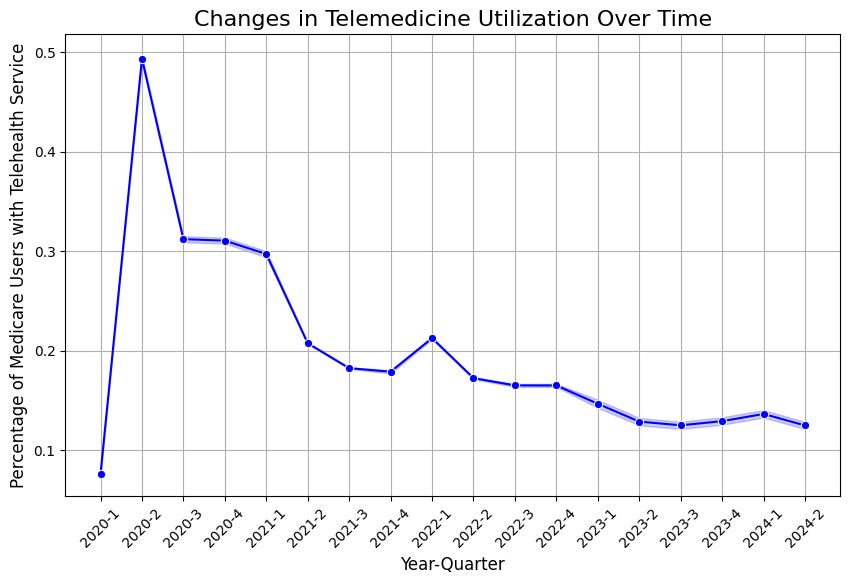

In [14]:
# Create line plot visualization for first research question (Changes in Telemedicine Utilization)
filtered_data = final_merged_data_clean[~final_merged_data_clean['year-quarter'].str.contains('overall', case=False, na=False)]

plt.figure(figsize=(10, 6))
sns.lineplot(x='year-quarter', y='pct_telehealth', data=filtered_data, marker='o', color='b')
plt.title('Changes in Telemedicine Utilization Over Time', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=12)
plt.ylabel('Percentage of Medicare Users with Telehealth Service', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

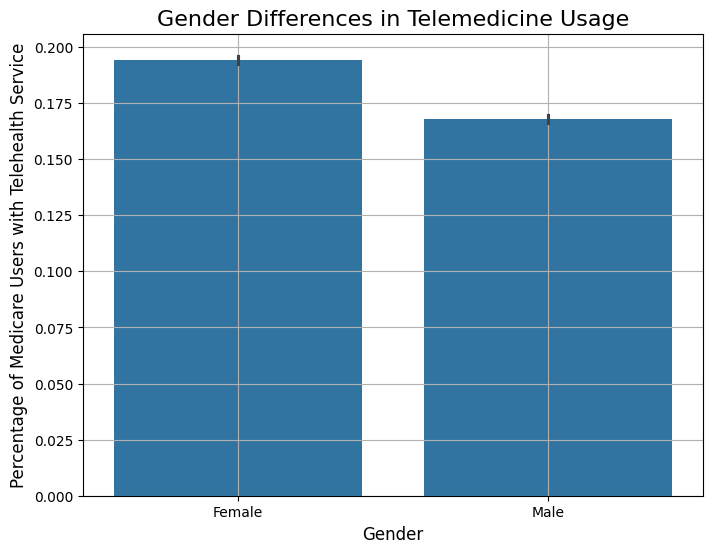

In [15]:
# Create bar plot for second research question (gender differences in telemedicine usage)

gender_data = final_merged_data_clean[['sex', 'pct_telehealth']]
gender_data_clean = gender_data.dropna()
plt.figure(figsize=(8, 6))

sns.barplot(x='sex', y='pct_telehealth', data=gender_data_clean)

plt.title('Gender Differences in Telemedicine Usage', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Percentage of Medicare Users with Telehealth Service', fontsize=12)

plt.grid(True)
plt.show()

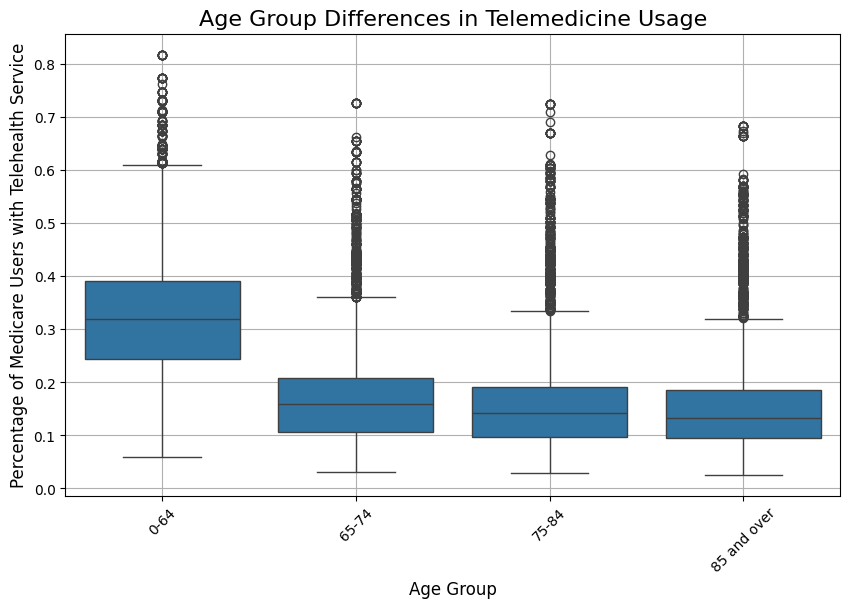

In [16]:
# Create box plot for second research question (for age group differences in telemedicine usage)

age_data = final_merged_data_clean[['age_group', 'pct_telehealth']]
age_data_clean = age_data.dropna()

plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='pct_telehealth', data=age_data_clean)
plt.title('Age Group Differences in Telemedicine Usage', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Percentage of Medicare Users with Telehealth Service', fontsize=12)

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

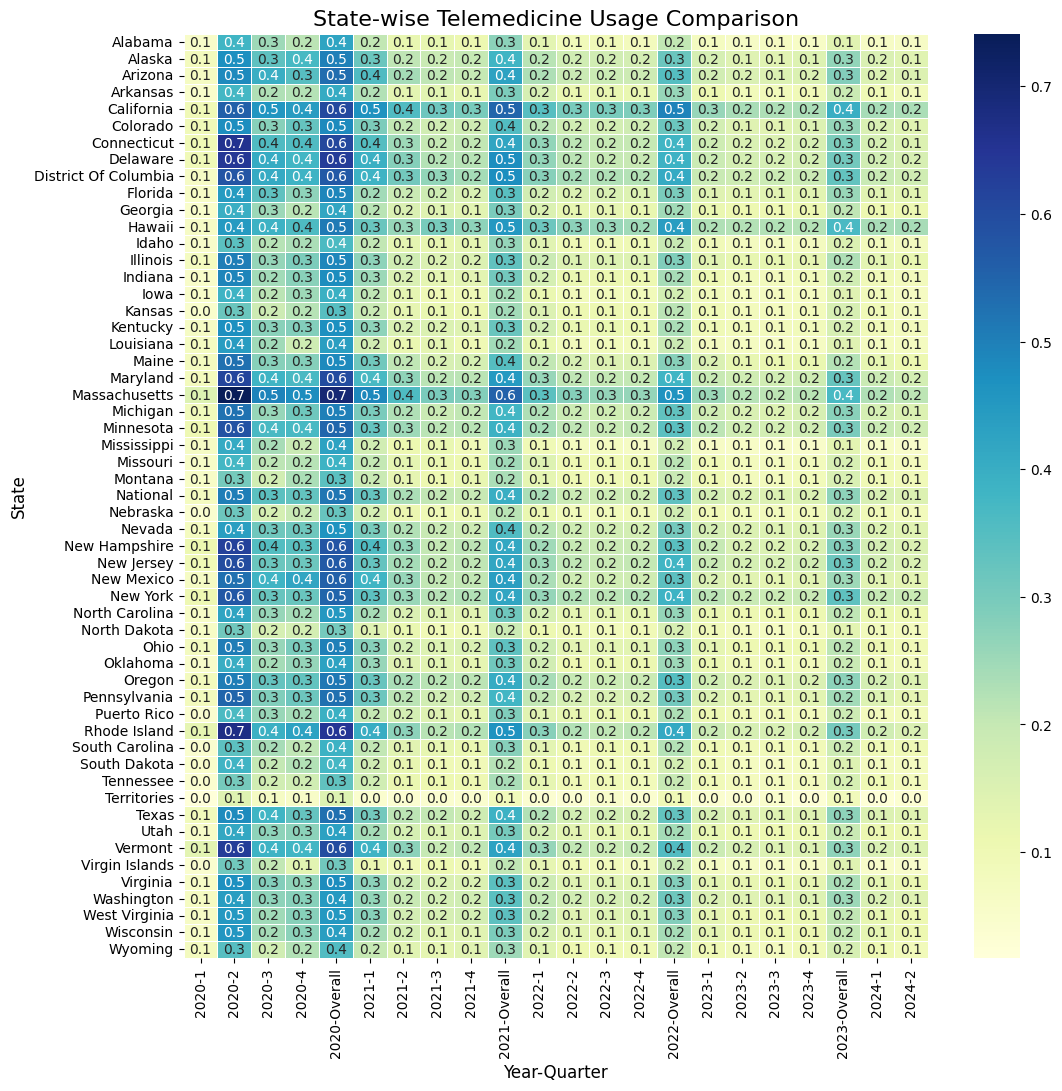

In [17]:
# Create heat map for second research question (for state-wise telemedicine usage comparisons)

state_data = final_merged_data_clean[['state', 'pct_telehealth', 'year-quarter']]
state_data_clean = state_data.dropna()

state_pivot = state_data_clean.pivot_table(values='pct_telehealth', 
                                           index='state', 
                                           columns='year-quarter', 
                                           aggfunc='mean')

plt.figure(figsize=(12, 12))
sns.heatmap(state_pivot, cmap='YlGnBu', annot=True, fmt='.1f', linewidths=0.5)

plt.title('State-wise Telemedicine Usage Comparison', fontsize=16)
plt.xlabel('Year-Quarter', fontsize=12)
plt.ylabel('State', fontsize=12)

plt.show()